In [1]:
#default_exp anime.oudataloader

In [2]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fast.torch_basics import *
from fast.layers import *
from fast.data.all import *
from fast.data.block import *
from fast.optimizer import *
from fast.learner import *
from fast.metrics import *
from fast.callback.all import *
from fast.vision.all import *
from anime.ugatit import *

In [3]:
selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainA").ls())
anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainB").ls())

In [4]:
for p in Path("/home/fast/.fastai/data/selfie2anime/trainA").ls():
    print(p)

/home/fast/.fastai/data/selfie2anime/trainA/female_10.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10016.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10020.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10025.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_1003.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10042.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10044.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10055.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10057.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10074.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10087.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_1009.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10113.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10117.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10119.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_10124.jpg
/home/fast/.fastai/data/selfi

/home/fast/.fastai/data/selfie2anime/trainA/female_26968.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_26980.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_26984.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_26992.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27000.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27023.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27028.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27030.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_2704.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_2705.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27060.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27069.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27071.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_2708.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27093.jpg
/home/fast/.fastai/data/selfie2anime/trainA/female_27094.jpg
/home/fast/.fastai/data/sel

In [5]:
class CycleImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2 = self
        return show_image(torch.cat([img1,img2], dim=2),  ctx=ctx)

In [6]:
class CyclePair(Transform):
    def __init__(self,bItems):
        self.small = bItems #(aItems,bItems) if len(aItems)>len(bItems) else (bItems,aItems)
        self.assoc = self
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        return CycleImage(i, random.choice(self.small)) #CycleImage(self.large[i], random.choice(self.small))

In [7]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    x = array(x)
    if x.ndim==3:
        return tensor(x).permute(2,0,1).float()/255.
    elif x.ndim==2:
        return tensor(x)[None].repeat(3,1,1).float()/255.
OpenAndResize = TupleTransform(resized_image)

In [8]:
tm=[CyclePair(anime_imgs), OpenAndResize]+[ToTensor(),ByteToFloatTensor()]

In [9]:
class ToTensor(TupleTransform):
    "Convert item to appropriate tensor class"
    order = 15
@ToTensor
def encodes(self, o:CycleImage): return TensorImage(image2byte(o))

In [10]:
after_batch=[] #[Cuda()]#Cuda(),#+aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   #max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   #size=None, mode='bilinear', pad_mode=PadMode.Reflection)
tfm=Pipeline(tm, as_item=False) #+after_batch

In [11]:
tfm2=Pipeline([OpenAndResize]+[ToTensor(as_item=False),ByteToFloatTensor()],as_item=False) #+after_batch

In [12]:
class NoopTensor(Transform):
    def encodes(self, x): return torch.FloatTensor([0])

In [13]:
tfm2=Pipeline([NoopTensor],as_item=False)

In [14]:
tfmDs=DataSource(selfie_imgs,[tfm,tfm2])

In [15]:
dl=TfmdDL(tfmDs,bs=1, shuffle=False, num_workers=8,after_batch=after_batch)

In [16]:
db=DataBunch(dl)

In [17]:
class NoValidCallback(Callback) :
    def after_train(self):
        raise CancelEpochException

In [18]:
ugatit=UGATIT()
ugatit.build_model()

In [19]:
noop_loss = lambda x: torch.FloatTensor([0])

In [20]:
class UGATITLearner(Learner):
    "Group together a `model`, some `dbunch` and a `loss_func` to handle training"
    def __init__(self, dbunch, models, loss_funcs=None, opt_funcs=[SGD,SGD], lr=None, splitter=trainable_params, cbs=None,
                 cb_funcs=None, metrics=None, path=None, model_dir='models', wd_bn_bias=False, train_bn=True):
        store_attr(self, "dbunch,splitter,model_dir,wd_bn_bias,train_bn")
        self.model_GA2B,self.model_GB2A,self.model_DA,self.model_DB,self.model_LA,self.model_LB=models
        self.generators=nn.ModuleList([self.model_GA2B,self.model_GB2A])
        self.discriminators=nn.ModuleList([self.model_DA,self.model_DB,self.model_LA,self.model_LB])
        self.model=nn.ModuleList([self.generators,self.discriminators])
        self.models=self.model
        self.opt_funcG,self.opt_funcD=opt_funcs
        self.lr = defaults.lr if lr is None else lr
        #TODO: infer loss_func from data
        self.loss_funcs = L([CrossEntropyLossFlat()]) if loss_funcs is None else loss_funcs
        self.path = path if path is not None else getattr(dbunch, 'path', Path('.'))
        self.metrics = [m if isinstance(m, Metric) else AvgMetric(m) for m in L(metrics)]
        self.training,self.logger,self.opts = False,print,None
        self.cbs = L([])
        self.add_cbs(cbf() for cbf in L(defaults.callbacks[0])) #TODO Took out tracking due ot error
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in L(cb_funcs))
        self.ugatit_loss=UGATITLoss(models)
    
    def create_opt(self,opt_func,models):
        "Create an optimizer with `lr`"
        opt = opt_func(self.splitter(models), lr=self.lr)
        if not self.wd_bn_bias:
            for p in bn_bias_params(models):
                opt.state[p] = {**opt.state.get(p, {}), 'do_wd': False}
        if self.train_bn:
            for p in bn_bias_params(models, with_bias=False):
                opt.state[p] = {**opt.state.get(p, {}), 'force_train': True}
        return opt
    
    def create_opts(self):
        #generator
        optG=self.create_opt(self.opt_funcG,self.generators)
        #discriminator
        optD=self.create_opt(self.opt_funcD,self.discriminators)
        return (optG,optD)

    # models? which models get which inputs?
    def one_batch(self, i, b):
        self.iter = i
        try:
            
            self._split(b)
            print_loss=i%100==0
            if(print_loss):    
                print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            if self.epoch*self.n_iter+i > ((self.n_epoch*self.n_iter) // 2):
                self.lr -= (self.lr / ((self.n_epoch*self.n_iter) // 2))
                self.opts[0].set_hyper('lr',self.lr)
                self.opts[1].set_hyper('lr',self.lr)
            self('begin_batch')
            #self.pred = self.model_GA2B(self.xb[0][0]);             self('after_pred')
            l=self.ugatit_loss.generator_loss(self.xb[0])
            self.loss=l.item();         self('after_loss') #should use loss_func
            if not self.training: return
            l.backward();                           self('after_backward')
            if(print_loss): print('G_loss: '+str(l.item()))
            self.opts[0].step();                                self('after_step')
            self.opts[0].zero_grad()
            
            l = self.ugatit_loss.discriminator_loss(self.xb[0]); #self('after_loss2')
            l.backward();                           #self('after_backward2')
            if(print_loss): print('D_loss: '+str(l.item()))
            self.opts[1].step();                                #self('after_step2')
            self.opts[1].zero_grad()
            self.model_GA2B.apply(ugatit.Rho_clipper)
            self.model_GB2A.apply(ugatit.Rho_clipper)
            
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        "Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`."
        with self.added_cbs(cbs):
            if reset_opt or not self.opts: self.opts = self.create_opts()
            try:
                self._do_begin_fit(n_epoch)
                for epoch in range(n_epoch):
                    try:
                        print('Epoch: ' + str(epoch))
                        self.epoch=epoch;          self('begin_epoch')
                        self._do_epoch_train()
                        self._do_epoch_validate()
                    except CancelEpochException:   self('after_cancel_epoch')
                    finally:                       self('after_epoch')

            except CancelFitException: self('after_cancel_fit')
            finally:                   self('after_fit')


In [21]:
ugatit.optims[0]

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0001
)

In [34]:
def multi_model_params(models):
    ps=[]
    for m in models:
        ps+=[p for p in m.parameters() if p.requires_grad]
    return ps

learner=UGATITLearner(db,ugatit.models,[noop_loss,noop_loss],[Adam,Adam],0.0001,splitter=multi_model_params)
#.to_fp16() #should use [Adam,Adam]
learner.add_cb(NoValidCallback())

In [ ]:
learner.fit(300)

tensor(0.2504, grad_fn=<MseLossBackward>)
tensor(0.2506, grad_fn=<MseLossBackward>)
tensor(0.2504, grad_fn=<MseLossBackward>)
tensor(0.2505, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2505, grad_fn=<MseLossBackward>)
tensor(0.2506, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2504, grad_fn=<MseLossBackward>)
tensor(0.2505, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2506, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2506, grad_fn=<MseLossBackward>)
tensor(0.2505, grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2506, grad_fn=<MseLossBackward>)


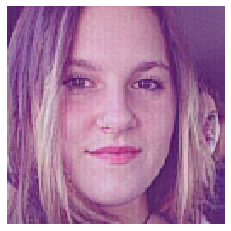

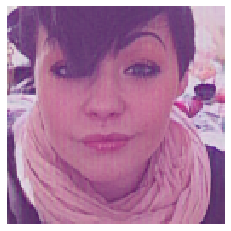

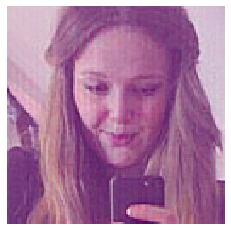

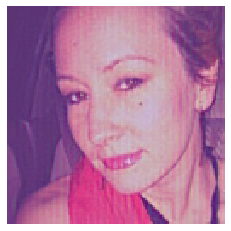

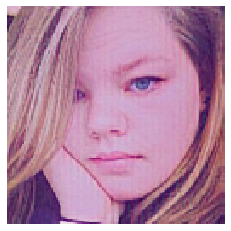

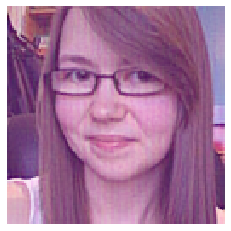

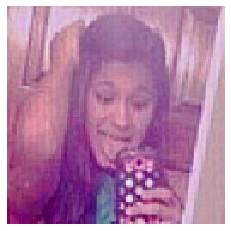

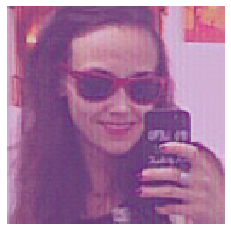

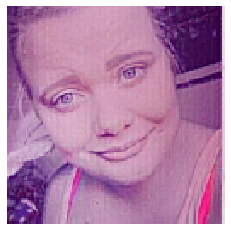

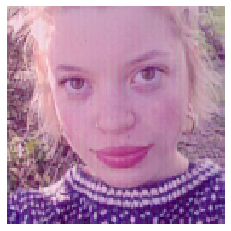

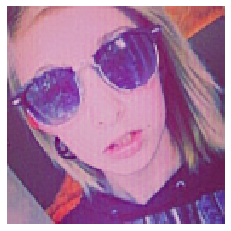

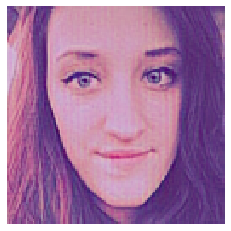

In [42]:
samples=[]
for i,(xb,yb) in enumerate(iter(db.train_dl)):
    xbA,xbB=xb
    fake_Bb=learner.model_GA2B(xbA)[0].detach()
    show_image(fake_Bb[0])
    prob=learner.model_DB(fake_Bb)
    #print(prob[0])
    print(nn.MSELoss()(prob[0], torch.full_like(prob[0],fill_value=0)))
    samples+=[fake_Bb[0]]
    if(i>10): break

In [ ]:
import pdb; pdb.set_trace()
learner.fit(1,lr=0.00001)

In [ ]:
fake_A2B

In [ ]:
learner.dbunch.one_batch()[0][0].shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

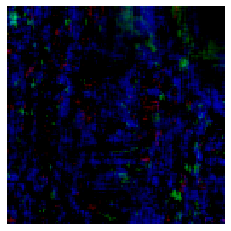

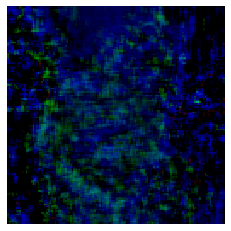

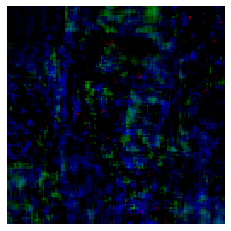

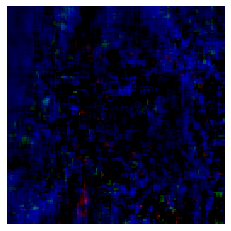

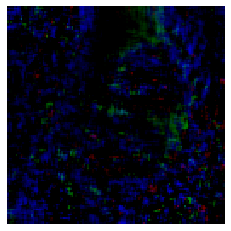

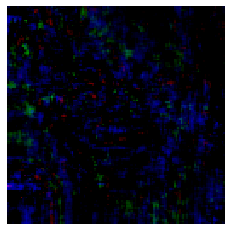

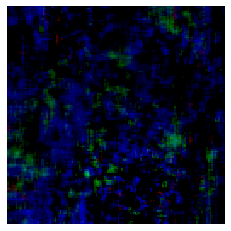

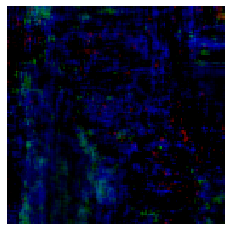

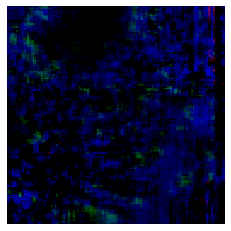

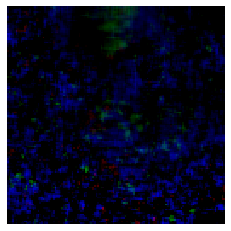

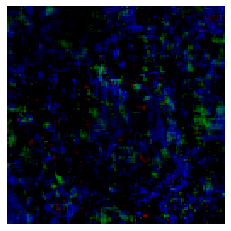

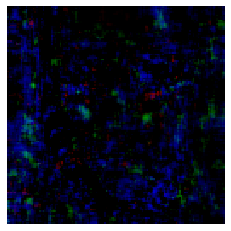

In [32]:
for i in range(len(samples)):
    show_image(samples[i])

In [ ]:
1000000/1700

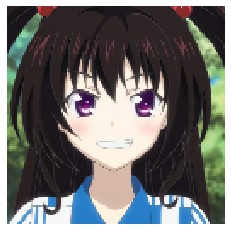

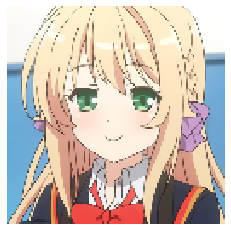

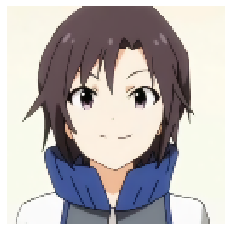

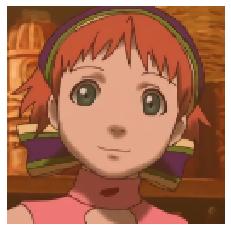

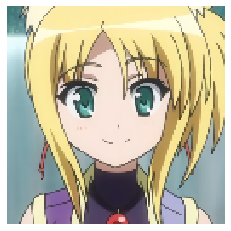

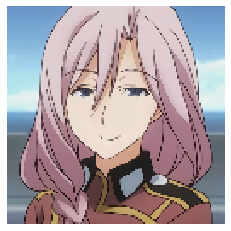

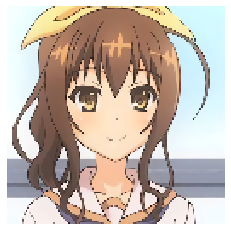

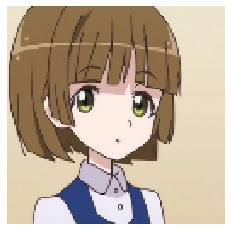

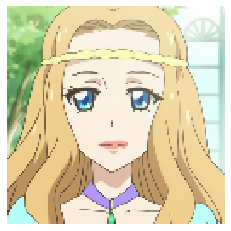

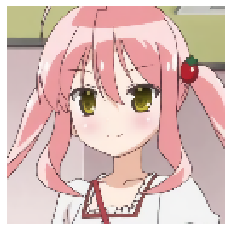

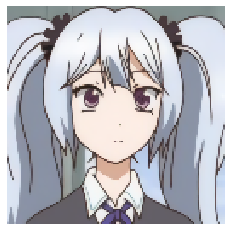

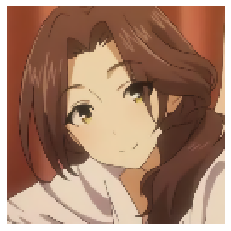

In [26]:
for i,(xb,yb) in enumerate(iter(db.train_dl)):
    xbA,xbB=xb
    show_image(xbB[0])
    if(i>10): break

In [40]:
learner.model_GA2B(xbA)

(tensor([[[[0.3735, 0.4054, 0.3981,  ..., 0.3987, 0.3869, 0.3686],
           [0.4088, 0.4378, 0.4006,  ..., 0.4192, 0.4131, 0.3950],
           [0.4658, 0.4920, 0.4365,  ..., 0.4364, 0.4186, 0.4026],
           ...,
           [0.7048, 0.6300, 0.6887,  ..., 0.3728, 0.3887, 0.3781],
           [0.7085, 0.6276, 0.7200,  ..., 0.3765, 0.3771, 0.3738],
           [0.7194, 0.6283, 0.7204,  ..., 0.3704, 0.3692, 0.3671]],
 
          [[0.2579, 0.2644, 0.2267,  ..., 0.2245, 0.2277, 0.2280],
           [0.2701, 0.2880, 0.2185,  ..., 0.2339, 0.2369, 0.2397],
           [0.3534, 0.3584, 0.2582,  ..., 0.2653, 0.2636, 0.2794],
           ...,
           [0.4650, 0.3140, 0.4032,  ..., 0.2401, 0.2459, 0.2551],
           [0.4887, 0.3282, 0.4496,  ..., 0.2288, 0.2315, 0.2373],
           [0.4925, 0.3149, 0.4532,  ..., 0.2244, 0.2311, 0.2361]],
 
          [[0.5329, 0.5538, 0.5313,  ..., 0.5128, 0.5098, 0.4965],
           [0.5578, 0.5715, 0.5336,  ..., 0.5193, 0.5201, 0.5052],
           [0.5911, 0.61

In [ ]:
#learner.save(Path('/home/fast/.fastai/m1'))

In [ ]:
Path('/home/fast/.fastai/m1')

In [ ]:
learner.save??

In [39]:
learner.load(Path('/home/fast/.fastai/m1'),with_opt=False)

In [38]:
learner.opt=True